# Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

## My Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
def compute_x_given_y(line, y):
    # Given a line, solve for x when y is specified

    # dx = x2 - x1
    # dy = y2 - y1
    dx = line[0][2] - line[0][0]
    dy = line[0][3] - line[0][1]

    return np.round(np.array([line[0][0] + (y - line[0][1]) * dx / dy, y]))

def fit_line(line, y_bottom, y_top):
    # Extend line from y_bottom to y_top

    coordinate_bottom = compute_x_given_y(line, y_bottom)
    coordinate_top = compute_x_given_y(line, y_top)

    return np.array([[coordinate_bottom[0], coordinate_bottom[1], coordinate_top[0], coordinate_top[1]]])


def get_slope(line):
    # Get the slope of the line

    if np.abs(float(line[0][2]) - float(line[0][0])) < 1e-6:
        return 1e6
    else:
        return (float(line[0][3]) - float(line[0][1])) / (float(line[0][2]) - float(line[0][0]))


def draw_lines(img, lines, y_coordinates, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    # sort the lines by their length computing the norm of each line
    lines = sorted(lines, key=lambda x: np.linalg.norm(x[0][2:] - x[0][:2]), reverse=True)

    # extend the lines to the bottom and top of the masked image
    lines = [fit_line(line, y_coordinates[0], y_coordinates[1]) for line in lines]

    selected_lines = [lines[0]]
    m0 = get_slope(lines[0])

    # the second line is the longest line with opposite slope of the first line
    for line in lines:
        m1 = get_slope(line)
        if np.sign(m1) != np.sign(m0):
            # get the top endpoints of the lines
            selected_lines.append(fit_line(line, y_coordinates[0], y_coordinates[1]))
            break

    # for line in lines:
    for line in selected_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (int(x1), int(y1)), (int(x2), int(y2)), color, thickness)

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    y_coordinates = [img.shape[0], 320]
    draw_lines(line_img, lines, y_coordinates)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Lane Finding Pipeline
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Applying Canny Edge detection to grayscale and smoothed original image
4. Define region of interest (only lane) using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw line segments on the black image
7. Draw full extend lines extrapolated from line segments
8. Overlap line image with original image


## Test on Images
Pipeline on directory "test_images"  

In [4]:
import os
images = os.listdir("test_images/")

In [7]:
# Pipeline code described above

def process_image(image, show=False):
    
    # Generate grayscale image from original
    gray_image = grayscale(image)

    # Applying Gaussian smoothing
    gaussian_image = gaussian_blur(gray_image, 5)

    # Canny edge detection
    edges = canny(gaussian_image, 50, 150)

    # Define region of interest
    vertices = np.array([[(0, image.shape[0]), (465, 320), (475, 320), (image.shape[1], image.shape[0])]],
                        dtype=np.int32)
    # Applying region of interest to Canny Edge output
    masked_edges = region_of_interest(edges, vertices)

    # Hough lines
    rho = 1               # distance resolution in pixels of the Hough grid
    theta = np.pi / 180   # angular resolution in radians of the Hough grid
    threshold = 20        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40  # minimum number of pixels making up a line
    max_line_gap = 100    # maximum gap in pixels between connectable line segments
    img_lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw lines in red on original image
    final = weighted_img(img_lines, image)

    if show:
        plt.figure()
        plt.subplot(2, 2, 1)
        plt.imshow(gray_image, cmap="gray")
        plt.title('Grayscale')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2BGR))
        plt.title('Canny Edge')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(img_lines)
        plt.title('Hough Transform')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(final)
        plt.title('Final')
        plt.axis('off')

    return final

*********** solidYellowCurve.jpg ***********


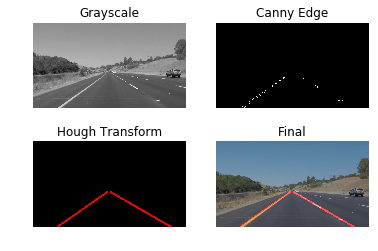

*********** solidYellowCurve2.jpg ***********


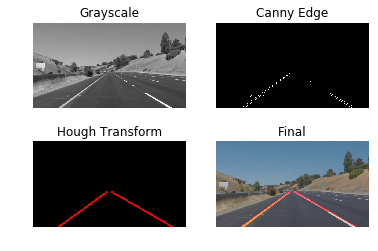

*********** solidWhiteCurve.jpg ***********


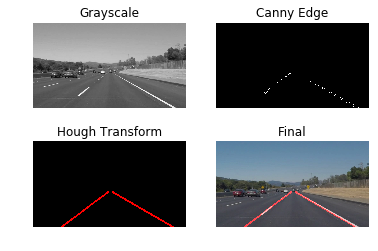

*********** solidWhiteRight.jpg ***********


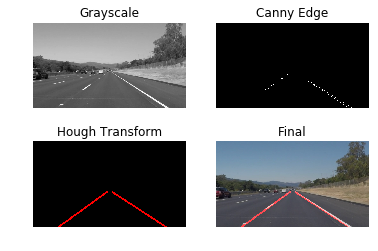

*********** solidYellowLeft.jpg ***********


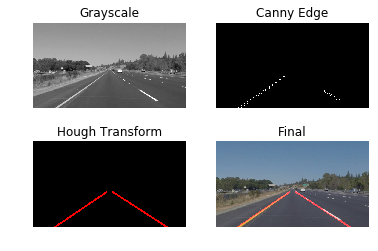

*********** whiteCarLaneSwitch.jpg ***********


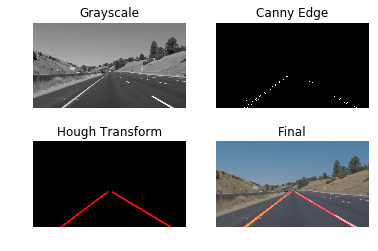

In [8]:
for img in images:
    # reading in an image
    image = mpimg.imread("test_images/"+img)
    process_image(image, True)
    print("*********** "+img+" ***********")
    plt.show()

## Test on Videos

Now we are going to draw lanes over video!

`solidWhiteRight.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 54.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 



In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

`solidYellowLeft.mp4`

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



 26%|██▌       | 179/682 [00:03<00:09, 51.54it/s]

ValueError: cannot convert float NaN to integer


 26%|██▌       | 179/682 [00:13<00:38, 13.16it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge Video

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))